## Imports and Setup

In [1]:
!pip install -U --pre tensorflow=="2.2.0"

  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0


In [2]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2394, done.
remote: Counting objects: 100% (2394/2394), done.
remote: Compressing objects: 100% (1996/1996), done.
remote: Total 2394 (delta 564), reused 1387 (delta 371), pack-reused 0
Receiving objects: 100% (2394/2394), 30.77 MiB | 26.98 MiB/s, done.
Resolving deltas: 100% (564/564), done.


In [3]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1614234 sha256=86d2e42de985eac75554bfb51ab2b0b736f97044569126fdf4192f3cf75c229d
  Stored in directory: /tmp/pip-ephem-wheel-cache-h5t619so/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.1-cp36-none-any.whl size=43734 sha256=a75e80a2626485a83c41edbbf894e942a8ca87354e58701de5d72c1e310b0372
  Stored in directory: /root/.cache/pip/wheels/65/fe/90/20d6d6d97223d80d20cb390be636619c536edab5658c12bdba
  Created wheel for dill: filename=dill-0.3.1.1-cp36-none-any.whl size=78533 sha256=13e3bbb272585f2e67bd15df1078cdeb245bd95d19b28c3659c0e484d8af5f3e
  Stored in directory: /root/.cache/pip/wheels/59/b1/91/f02e76c732915c4015ab4010f3015469866c1eb9b14058d8e7
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=f5b8142e460cf8b89e220ea8496e4f9b5548bbf671abbb7c79d1

ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.27.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.1 which is incompatible.


In [4]:
import io
import os
import scipy.misc
import numpy as np
import six
import time

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import visualization_utils as viz_utils

%matplotlib inline

## Utilities

In [6]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Load the  Label Map
category_index = {
    1: {'id': 1, 'name': 'human'}
}

## Build a detection model and load pre-trained model weights

In [7]:
# Download the saved model and put it into models/research/object_detection/test_data/
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_inception_resnet_v2_1024x1024_coco17_tpu-8.tar.gz
!tar -xf faster_rcnn_inception_resnet_v2_1024x1024_coco17_tpu-8.tar.gz
!mv faster_rcnn_inception_resnet_v2_1024x1024_coco17_tpu-8/ models/research/object_detection/test_data/

--2021-01-24 10:06:54--  http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_inception_resnet_v2_1024x1024_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.195.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447961769 (427M) [application/x-tar]
Saving to: ‘faster_rcnn_inception_resnet_v2_1024x1024_coco17_tpu-8.tar.gz’

faster_rcnn_incepti 100%[===================>] 427.21M   226MB/s    in 1.9s    

2021-01-24 10:06:57 (226 MB/s) - ‘faster_rcnn_inception_resnet_v2_1024x1024_coco17_tpu-8.tar.gz’ saved [447961769/447961769]



In [8]:
start_time = time.time()
tf.keras.backend.clear_session()
# add the path to model where the pretrained weights were moved
detect_fn = tf.saved_model.load('/content/models/research/object_detection/test_data/faster_rcnn_inception_resnet_v2_1024x1024_coco17_tpu-8/saved_model/')
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

Elapsed time: 23.989383935928345s


- Run the below code which loads an image, runs it through the detection model and visualizes the resuls including the keypoints.

- Before running this image make sure to upload the image and specify the path for 'image_path'

Elapsed time: 29.639781594276428 second per image


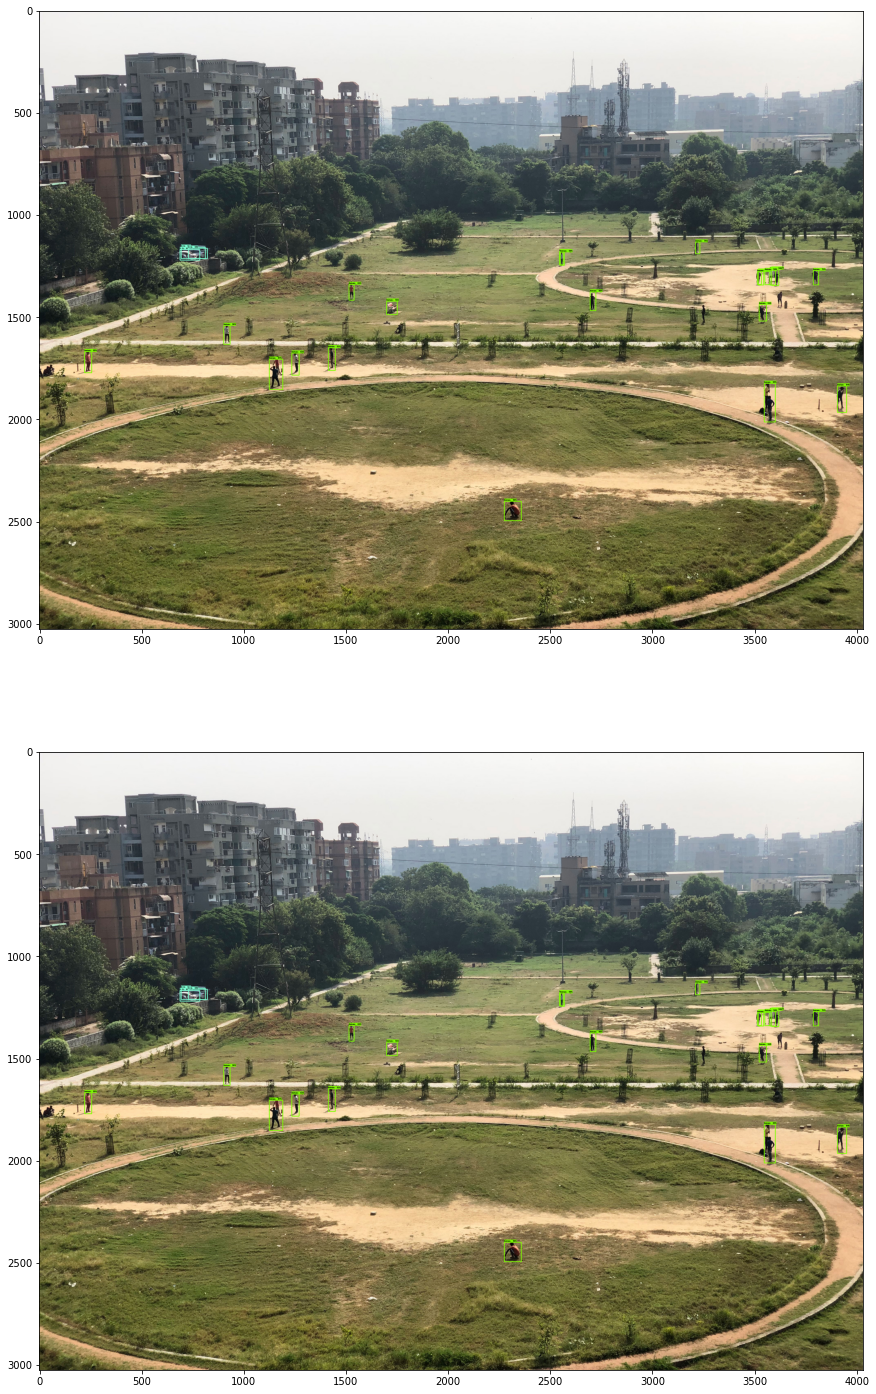

In [10]:
import time

image_dir = 'models/research/object_detection/test_images'

elapsed = []
for i in range(2):
  image_path = '/content/models/research/object_detection/test_images/TopDownHumanDetection_4032x3024.jpg'
  image_np = load_image_into_numpy_array(image_path)
  input_tensor = np.expand_dims(image_np, 0)
  start_time = time.time()
  detections = detect_fn(input_tensor)
  end_time = time.time()
  elapsed.append(end_time - start_time)

  plt.rcParams['figure.figsize'] = [50, 25]
  label_id_offset = 1
  image_np_with_detections = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.int32),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.40,
        agnostic_mode=False)
  plt.subplot(2, 1, i+1)
  plt.imshow(image_np_with_detections)

mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')

- Change the color of bounding box to red.

Elapsed time: 27.646445512771606 second per image


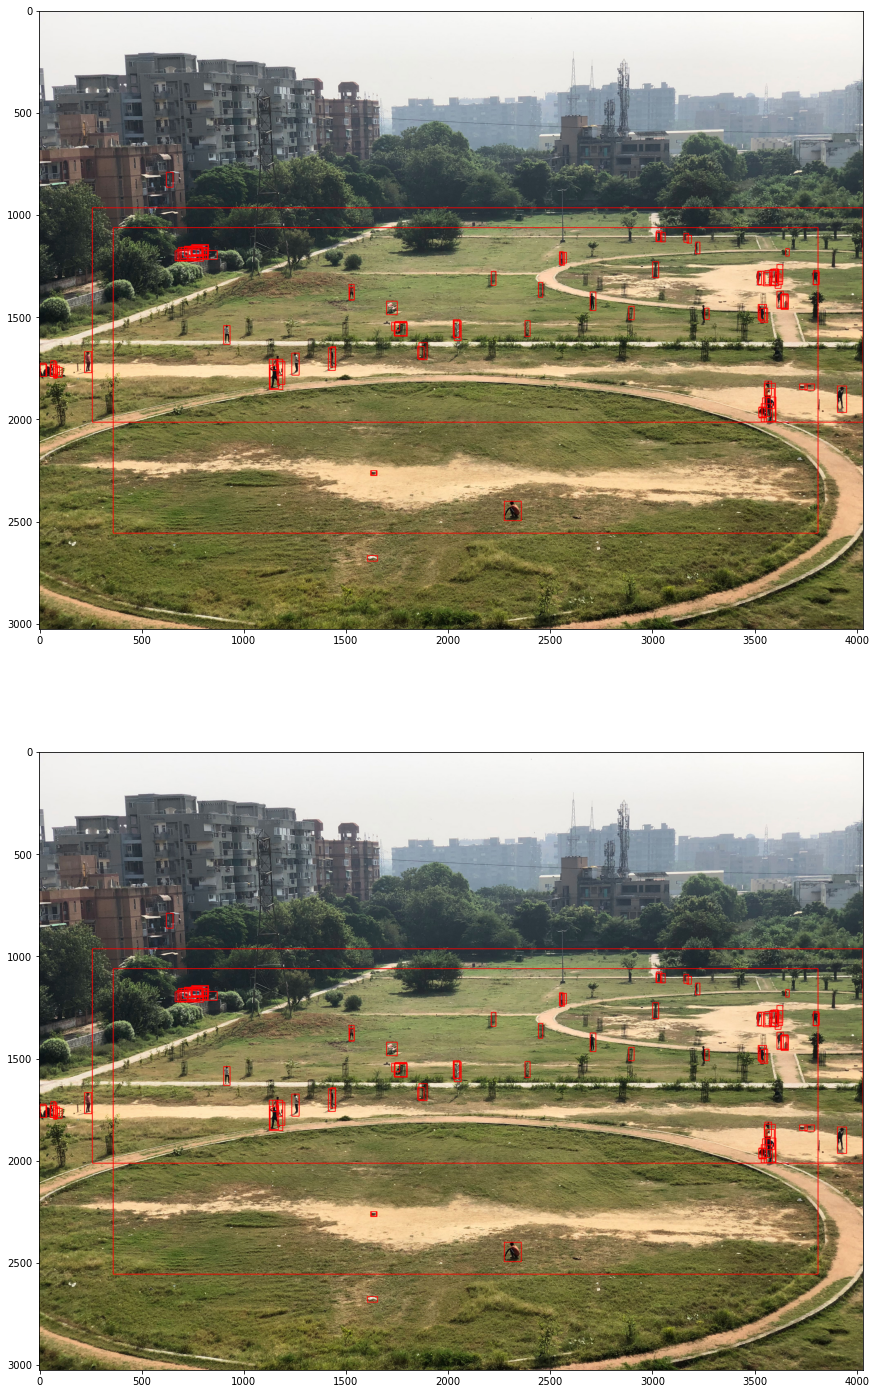

In [11]:
import time

image_dir = 'models/research/object_detection/test_images'

elapsed = []
for i in range(2):
  # image_path = os.path.join(image_dir, 'image' + str(i + 1) + '.jpg')
  image_path = '/content/models/research/object_detection/test_images/TopDownHumanDetection_4032x3024.jpg'
  image_np = load_image_into_numpy_array(image_path)
  input_tensor = np.expand_dims(image_np, 0)
  start_time = time.time()
  detections = detect_fn(input_tensor)
  end_time = time.time()
  elapsed.append(end_time - start_time)

  plt.rcParams['figure.figsize'] = [50, 25]
  label_id_offset = 1
  image_np_with_detections = image_np.copy()
  viz_utils.draw_bounding_boxes_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      color = 'red',
      thickness = 4
  )
  plt.subplot(2, 1, i+1)
  plt.imshow(image_np_with_detections)

mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')

# Intersection Over Union(IOU)
- IOU is a metric that finds the difference between ground truth annotations and predicted bounding boxes.
- In object detection, the model predicts multiple bounding boxes for each object and based on the confidence scoresof each bounding box it removes  unnecessary boxes based on the threshold value. We need to declare the threshold value based on our requirements.

- IOU =   Area of union /  area of intersection

In [ ]:
# Just a sample snippet to calculate IOU
def IOU(box1, box2):

    x1, y1, w1, h1 = box1

    x2, y2, w2, h2 = box2

    w_intersection = min(x1 + w1, x2 + w2) - max(x1, x2)

    h_intersection = min(y1 + h1, y2 + h2) - max(y1, y2)

    if w_intersection <= 0 or h_intersection <= 0: 

        return 0

    I = w_intersection * h_intersection

    U = w1 * h1 + w2 * h2 - I 

    return I / U

iou = [IOU(y_test[i], y_pred[i]) for i in range(len(x_test))]